# Wheat Crop Phenology

## Table of Contents
1. [Problem Statement](#Problem-Statement)
2. [Dataset](#Dataset)
    - [DAYMET](#DAYMET)
    - [MODIS NDVI](#MODIS-NDVI)
3. [MAIN FLOW](#MAIN-FLOW)
4. [NDVI Smoothing](#NDVI-Smoothing)
5. [Helper Functions](#Helper-Functions)
    - [Two Peak Double Logistic fitting](#Two-Peak-Double-Logistic-fitting)
    - [Double Logistic Loss](#Double-Logistic-Loss)
    - [Dividing Index](#Dividing-Index)
    - [Troughs and Crests](#Troughs-and-Crests)


## Problem Statement
Given MODIS NDVI values and DAYMET temperature values, estimate the required crop growth metrics Day-of-Year (DOY) for wheat crop. The approach is to use a double logistic curve to fit the NDVI values and then use the fitted curve to estimate the phenological features. These features in addition to APTT values calculated from DAYMET temperature values are used to estimate the DOY values for crop growth metrics.

## Initial Setup

Import necessary modules, paths and variables.

In [1]:
import os
import numpy as np
from numpy.lib.function_base import diff
import pandas as pd
from scipy.optimize import least_squares
from scipy import signal
from scipy.special import expit
import rasterio
import matplotlib.pyplot as plt
from unittest import result
import rasterio
from tqdm import tqdm

### APTT Generation Parameters

In [2]:
generate_aptt = True

daymet_path = 'daymet_data'
output_aptt_path = 'daymet_data/APTT_winterwheat'
start_aptt_generation_year = 2020
end_aptt_generation_year = 2021

Tmin_Veg = 0.0
Tmax_Veg = 35.0
Topt_Veg = 24.0
P_critical_Veg = 23.0
P_optimum_Veg = 11.0

Tmin_Rep = 8.0
Tmax_Rep = 40.0
Topt_Rep = 29.0
P_critical_Rep = 18.0
P_optimum_Rep = 12.0

### Double Logistic Curve Fitting Parameters

In [3]:
ndvi_path = 'NDVI_data'
usda_path = 'USDA_data'

# Minimum: 2009, Maximum: 2018
ndvi_start_year = 2012
ndvi_end_year = 2018

if ndvi_start_year < 2009 or ndvi_end_year > 2018:
    print('Error: ndvi_start_year must be greater than or equal to 2009 and ndvi_end_year must be less than or equal to 2018')
    exit()

### APTT Average Estimation Parameters

In [4]:
aptt_start_year = 2020
aptt_end_year = 2020

## Dataset

### DAYMET

In [5]:
# TODO

### MODIS NDVI

There are two datasets used in this notebook. The first dataset is the MODIS NDVI values for the years 2000-2016. These are used to fit a double logistic curve.

This data is the state-average calculated data. Let's load and plot the data.

We want to filter in only dates from and to the 249th day of the year. This is because we want to fit the curve to the growing season only.

In [6]:
def get_data(year):
    state_avg_ndvi_year = pd.read_csv(os.path.join(ndvi_path, 'state_average_wheat_NDVI_'+str(year-1)+'_'+str(year)+'.csv'), usecols=['year', 'doy', 'NDVI'])

    df = state_avg_ndvi_year[
        ((state_avg_ndvi_year.year == year-1) & (state_avg_ndvi_year.doy >= 249)) | 
        ((state_avg_ndvi_year.year == year) & (state_avg_ndvi_year.doy <= 249))
    ]

    ndvi = np.array(df['NDVI']).astype(float)
    doy = np.array(df['doy']+365*(df['year']-df.iloc[0]['year'])).astype(float)

    # The overhead is doy[0], hence we subtact the overhead from doy
    doy = doy - doy[0]

    return ndvi, doy

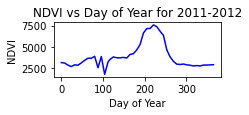

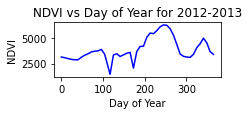

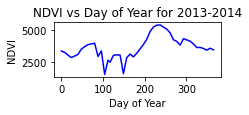

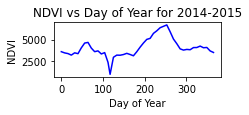

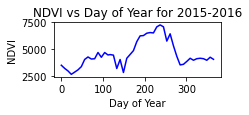

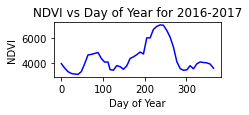

In [7]:
for year in range(ndvi_start_year,ndvi_end_year):
    ndvi, doy = get_data(year)

    # Plot the NDVI
    plt.figure(figsize=(3,1))
    plt.plot(doy, ndvi, 'b-')
    plt.xlabel('Day of Year')
    plt.ylabel('NDVI')
    plt.title('NDVI vs Day of Year for '+str(year-1)+'-'+str(year))
    plt.show()    

## Helper Functions

(APTT GENERATION HELPER FUNCTIONS)

### Inialize Rasters

In [8]:
def initialize_rasters(tmin_path, tmax_path, dayl_path):
    
    raster1=rasterio.open(tmin_path)
    tmin=raster1.read()
    tmin=np.delete(tmin, list(range(181,365)), 0)

    raster2=rasterio.open(tmax_path)
    tmax=raster2.read()
    tmax=np.delete(tmax, list(range(181,365)), 0)

    t = (0.5*np.add(tmin,tmax))

    raster3=rasterio.open(dayl_path)
    dayl=raster3.read()/3600.0

    return (tmin, tmax, t, dayl, raster1.height, raster1.width)

(DOUBLE LOGISTIC CURVE FITTING HELPER FUNCTIONS)

### Double Logistic Value
This function returns the value of the double logistic curve at a given DOY value and the parameters for the double logistic curve.

In [9]:
def get_double_logistic_value(doy, params):
    t = np.array(doy)
    result = params[4] + (params[5]-params[4]) * (expit(params[0] * (t - params[1])) - expit(params[2] * (t - params[3])))
    return result

### Double Logistic Loss
The loss function is the sum of the differences between the actual ndvi and predicted double logistic ndvi values.

In [10]:
def double_logistic_loss(params, ndvi, doy):
    output = []
    losses = ndvi - get_double_logistic_value(doy, params)
    for loss in losses:
        output.append(loss)
    return np.array(output).squeeze()

### Troughs and Crests
Find the derivative of the fitted NDVI curve.
Use scipy.signal.find_peaks to find the peaks and troughs.

In [11]:
def get_troughs_and_crests(fitted_ndvi):
    diffn = np.diff(fitted_ndvi)
    crests, crest_values = signal.find_peaks(diffn, height=0)
    troughs, trough_values = signal.find_peaks(-diffn, height=0)    
    return troughs, crests

### Dividing Index
Find the index where the fitted NDVI changes from the first peak to the second peak.
Can be estimated as a function of troughs and crests.

In [12]:
def get_dividing_index(fitted_ndvi):
    # troughs, crests = get_troughs_and_crests(fitted_ndvi)
    # print('Trough:',troughs,'\tCrest:',crests)
    # # Figure out why
    # if troughs[0] < crests[0] and len(troughs) > len(crests):
    #     troughs = troughs[1:]

    # if len(troughs)==2:
    #     dividing_index = int(((2*troughs[0])+troughs[1])/3)
    # elif len(crests)==2:
    #     dividing_index = int((crests[0]+crests[1])/2)
        
    # The dividing index is the index of the first trough after the first crest
    # return dividing_index
    return 130

### Double Logistic fitting
Identify if the curve is vegetative or reproductive.
Use least square optimization to fit the curve using single peak double logistic loss.
Make the Doys continuous and obtain the smooth fitted curve.

In [13]:
def fit_ndvi(ndvi,doy,peak,end_doy):
    if peak == 'vegetative':
        init_params = [0.2, 50, 0.2, 100, 2500, 4500]
        lower_bounds = [0.1, 25, 0.1, 75, 2000, 3800]
        higher_bounds = [1, 75, 0.25, 150, 4000, 5500]
    elif peak == 'reproductive':
        init_params = [0.15, 160, 0.2, 275, 3500, 7000]
        lower_bounds = [0.05, 50, 0.05, 150, 3000, 5500]
        higher_bounds = [0.25, 250, 0.25, 350, 4000, 9000]
    else:
        raise Exception('Invalid peak type')

    result = least_squares(
        double_logistic_loss,
        init_params,
        bounds=(lower_bounds, higher_bounds),
        max_nfev=100000,
        args=(ndvi,doy)
    )

    xsol = result.x

    doy = np.arange(doy[0], end_doy, 1)

    fitted_ndvi = xsol[4] + (xsol[5]-xsol[4]) * (expit(xsol[0] * (doy - xsol[1])) - expit(xsol[2] * (doy - xsol[3])))

    
    return fitted_ndvi, doy

(ESTIMATING DOY VALUES FOR CROP GROWTH METRICS HELPER FUNCTIONS)

### Extract the Phenological Features
This function uses the vegetation and reproductive ndvi and their derivates. It uses the troughs and crests on them to find the phenological features.

<b>Vegetative Active Greenup</b> : Crest of the first derivative of the vegetative peak

<b>Reproductive Active Greenup</b> : Crest of the first derivative of the reproductive peak

<b>Reproductive Senescence</b> : Trough of the third derivative of the reproductive peak

In [14]:
def get_phenological_doy(vegetative_ndvi,reproductive_ndvi):
    
    vegetative_ndvi_diff1 = np.diff(vegetative_ndvi)
    vegetative_ndvi_diff2 = np.diff(vegetative_ndvi_diff1)
    vegetative_ndvi_diff3 = np.diff(vegetative_ndvi_diff2)
    
    vegetative_crests_diff1, _ = signal.find_peaks(vegetative_ndvi_diff1, height=0)
    vegetative_greenup = int(vegetative_crests_diff1[0])
    
    reproductive_ndvi_diff1 = np.diff(reproductive_ndvi)
    reproductive_ndvi_diff2 = np.diff(reproductive_ndvi_diff1)
    reproductive_ndvi_diff3 = np.diff(reproductive_ndvi_diff2)
    
    reproductive_crests_diff1, _ = signal.find_peaks(reproductive_ndvi_diff1, height=0)
    reproductive_greenup = int(reproductive_crests_diff1[0])

    reproductive_troughs_diff1, _ = signal.find_peaks(-reproductive_ndvi_diff1, height=0)
    reproductive_senescense = int(reproductive_troughs_diff1[0])

    return {
        'vegetative_ndvi_diff1': vegetative_ndvi_diff1, 
        'vegetative_ndvi_diff2': vegetative_ndvi_diff2,
        'vegetative_ndvi_diff3': vegetative_ndvi_diff3,

        'vegetative_greenup': vegetative_greenup,
        
        'reproductive_ndvi_diff1': reproductive_ndvi_diff1, 
        'reproductive_ndvi_diff2': reproductive_ndvi_diff2,
        'reproductive_ndvi_diff3': reproductive_ndvi_diff3,

        'reproductive_greenup': reproductive_greenup,
        'reproductive_senescense': reproductive_senescense
    }

(PLOTTING HELPER FUNCTIONS)

### Plotting values

Use the global variables to plot the values.

In [15]:
total_number_of_years = ndvi_end_year - ndvi_start_year
def plot_ndvi(x,y,title,data,discrete):
    # plt.figure(figsize=(total_number_of_years*10,total_number_of_years*2))
    plt.figure(figsize=(35,10))
    plt.plot(x, y)
    if discrete:
        plt.plot(discrete[0], discrete[1], '--')
    plt.xlabel('Day of Year')
    plt.ylabel('NDVI')
    plt.title(title)        

    # Set markersize to 20 by default
    plt.rcParams['lines.markersize'] = 15

    # Set Marker border width to 2 by default
    plt.rcParams['lines.markeredgecolor'] = 'black'
    
    for i, (vegetative_greenup, reproductive_greenup, reproductive_senescense, emergence, joint, heading, turning, ripening, harvesting)  in enumerate(data):
        
        plt.axvline(x.index(vegetative_greenup), color='green', linestyle='--', alpha=0.5)
        plt.axvline(x.index(reproductive_greenup), color='green', linestyle='--', alpha=0.5)
        plt.axvline(x.index(reproductive_senescense), color='red', linestyle='--', alpha=0.5)

        plt.plot(emergence, y[x.index(emergence)], 'yo', alpha=0.9)
        plt.plot(joint, y[x.index(joint)], 'co', alpha=0.9)
        plt.plot(heading, y[x.index(heading)], 'mo', alpha=0.9)
        plt.plot(turning, y[x.index(turning)], 'ko', alpha=0.9)
        plt.plot(ripening, y[x.index(ripening)], 'bo', alpha=0.9)
        plt.plot(harvesting, y[x.index(harvesting)], 'go', alpha=0.9)

        
    # Give labels to the points based on color
    plt.plot([], [], 'yo', label='Emergence')
    plt.plot([], [], 'co', label='Joint')
    plt.plot([], [], 'mo', label='Heading')
    plt.plot([], [], 'ko', label='Turning')
    plt.plot([], [], 'bo', label='Ripening')
    plt.plot([], [], 'go', label='Harvesting')

    plt.xticks([x.index(249)], ['249'])
    plt.xticks([i*365 for i in range(total_number_of_years+1)], [i+ndvi_start_year for i in range(total_number_of_years+1)])
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

## MAIN FLOW : APTT GENERATION

Alpha Values for the APTT calculation

In [16]:
alpha_Veg = np.log(2)/np.log((Tmax_Veg-Tmin_Veg)/(Topt_Veg-Tmin_Veg))
alpha_Rep = np.log(2)/np.log((Tmax_Rep-Tmin_Rep)/(Topt_Rep-Tmin_Rep))

m = 3
alpha_photo_Veg = np.log(2)/np.log((P_critical_Veg-P_optimum_Veg)/m + 1)
alpha_photo_Rep = np.log(2)/np.log((P_critical_Rep-P_optimum_Rep)/m + 1)

For each year:
1. Calculate the APTT values for the year using the DAYMET temperature values and the alpha values per pixel.
2. Group the APTT values for the year for a given state into a raster. (Multiple areas are covered by a single state).

Output is a raster for each year of dimensions ???.
This raster is used to calculate the APTT values for the NDVI values.
Output stored in the path: daymet_data/APTT_winterwheat/APTT_winterwheat_*_year.tif

In [17]:
start_aptt_generation_year = 2020
end_aptt_generation_year = 2021
if generate_aptt:
    # Supress invalid value warnings
    np.seterr(invalid='ignore')
    for year in tqdm(range(start_aptt_generation_year,end_aptt_generation_year)):

        tmin_path = os.path.join(daymet_path, 'daymet_data_tmin', 'tmin_'+str(year)+'.tif')
        tmax_path = os.path.join(daymet_path, 'daymet_data_tmax', 'tmax_'+str(year)+'.tif')
        dayl_path = os.path.join(daymet_path, 'daymet_data_dayl', 'daylength_'+str(year)+'.tif')
        
        outfile_Veg = os.path.join(output_aptt_path, 'APTT_winterwheat_vegetative_phase_'+str(year)+'.tif')
        outfile_Rep = os.path.join(output_aptt_path, 'APTT_winterwheat_reproductive_phase_'+str(year)+'.tif')

        tmin, tmax, t, dayl, tot_rows, tot_cols = initialize_rasters(tmin_path, tmax_path, dayl_path)
    
        # Initialize the APTT arrays
        ft1=np.copy(t)
        ft1[t>=Tmax_Veg]=0
        ft1[t<=Tmin_Veg]=0        
        ft1[(t<Tmax_Veg) & (t>Tmin_Veg)]=((2 * (t-Tmin_Veg)**alpha_Veg * (Topt_Veg-Tmin_Veg)**alpha_Veg - (t-Tmin_Veg)**(2*alpha_Veg))/((Topt_Veg-Tmin_Veg)**(2*alpha_Veg)))[(t<Tmax_Veg) & (t>Tmin_Veg)]
        ft1[np.where(ft1<0)]=0 

        ft2=np.copy(t)
        ft2[t>=Tmax_Rep]=0
        ft2[t<=Tmin_Rep]=0        
        ft2[(t<Tmax_Rep) & (t>Tmin_Rep)]=((2 * (t-Tmin_Rep)**alpha_Rep * (Topt_Rep-Tmin_Rep)**alpha_Rep - (t-Tmin_Rep)**(2*alpha_Rep))/((Topt_Rep-Tmin_Rep)**(2*alpha_Rep)))[(t<Tmax_Rep) & (t>Tmin_Rep)]
        ft2[np.where(ft2<0)]=0 

        c=dayl
        fp1=np.copy(c)
        fp1[c>=P_critical_Veg]=0
        fp1[c<=P_optimum_Veg]=1        
        fp1[(c<P_critical_Veg) & (c>P_optimum_Veg)]=((((c-P_optimum_Veg)/3 + 1)*((P_critical_Veg-c)/(P_critical_Veg-P_optimum_Veg))**((P_critical_Veg-P_optimum_Veg)/3))**alpha_photo_Veg)[(c<P_critical_Veg) & (c>P_optimum_Veg)]
        fp1[np.where(fp1<0)]=0    

        fp2=np.copy(c)
        fp2[c>=P_critical_Rep]=0
        fp2[c<=P_optimum_Rep]=1      
        fp2[(c<P_critical_Rep) & (c>P_optimum_Rep)]=((((c-P_optimum_Rep)/3 + 1)*((P_critical_Rep-c)/(P_critical_Rep-P_optimum_Rep))**((P_critical_Rep-P_optimum_Rep)/3))**alpha_photo_Rep)[(c<P_critical_Rep) & (c>P_optimum_Rep)]
        fp2[np.where(fp2<0)]=0  

        fpt1=ft1*fp1
        fpt2=ft2*fp2

        src=rasterio.open(tmin_path)
        profile=src.profile
        profile.update(count=fpt1.shape[0])

        with rasterio.open(outfile_Veg, 'w', **profile) as dst:
            for i in range(fpt1.shape[0]):
                dst.write(fpt1[i,:,:].astype(rasterio.float32), i+1)
        
        with rasterio.open(outfile_Rep, 'w', **profile) as dst:
            for i in range(fpt2.shape[0]):
                dst.write(fpt2[i,:,:].astype(rasterio.float32), i+1)

100%|█████████████████████████████████████████████| 1/1 [00:30<00:00, 30.46s/it]


In [18]:
# Read in the APTT rasters for one year
aptt_veg_path = os.path.join(output_aptt_path, 'APTT_winterwheat_vegetative_phase_'+str(end_aptt_generation_year-1)+'.tif')
aptt_rep_path = os.path.join(output_aptt_path, 'APTT_winterwheat_reproductive_phase_'+str(end_aptt_generation_year-1)+'.tif')

with rasterio.open(aptt_veg_path) as src:
    aptt_veg = src.read()
    aptt_veg_meta = src.profile

with rasterio.open(aptt_rep_path) as src:
    aptt_rep = src.read()
    aptt_rep_meta = src.profile

print(aptt_veg.shape)
print(aptt_rep.shape)

(181, 443, 693)
(181, 443, 693)


## MAIN FLOW : DOUBLE LOGISTIC CURVE FITTING

<b>For each year, perform:</b>
- <b>NDVI Two peak fitting</b>
It can be observed that the NDVI values have two peaks. The first peak is the vegetative growth phase and the second peak is the reproductive growth phase. The double logistic curve is a good fit for this data. To determine the parameters for the double logistic curve, we will use the `scipy.optimize.least_squares` function. 

- Get Dividing Index
- Plot the fitted curve with the actual data and the dividing index

- <b>Individiual Double Logistic Curve Fitting</b>
Split the ndvi and doy into two parts: vegetative and reproductive using the dividing index. Perform least square optimization to fit the double logistic curve to this data individually. This will give us the parameters for the double logistic curve for the vegetative and reproductive growth phases.
- <b>Phenological Features Estimation</b>
Use the fitted curves to estimate the phenological features. The phenological features are:
    - Vegetative Active Greenup
    - Vegetative End of Senescence
    - Reproductive Active Greenup
    - Reproductive End of Senescence
- Add the necessary values to global variables

### Perform Double Logistic Curve Fitting

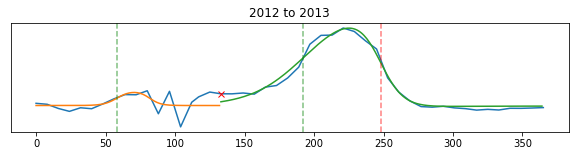

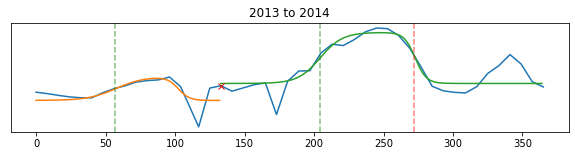

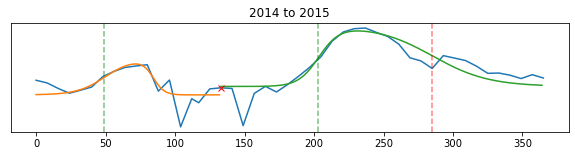

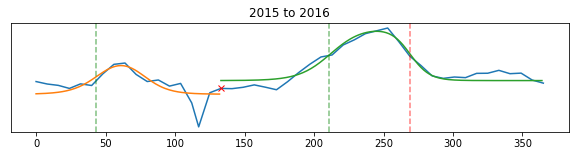

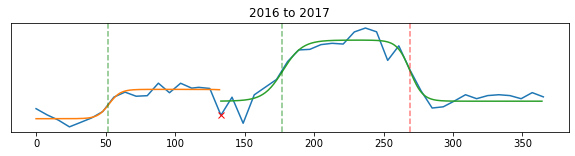

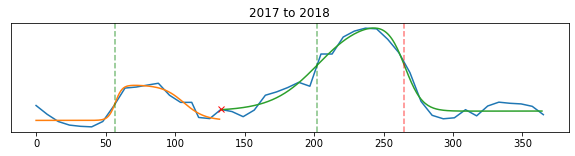

Vegetative greenup:  [58, 422, 779, 1138, 1512, 1882]
Reproductive greenup:  [192.0, 569.0, 933.0, 1306.0, 1637.0, 2027.0]
Reproductive senescense:  [248.0, 637.0, 1015.0, 1364.0, 1729.0, 2090.0]


In [19]:
ndvis_discrete, ndvis, ndvis_diff1, ndvis_diff2, ndvis_diff3 = [], [], [], [], []
doys_discrete, doys, doys_diff1, doys_diff2, doys_diff3 = [], [], [], [], []

vegetative_greenups, reproductive_greenups, reproductive_senescense = [], [], []

for year in range(ndvi_start_year,ndvi_end_year):
    ndvi,doy = get_data(year)
    # fitted_two_peak_ndvi, doy_cont = fit_two_peak_ndvi(ndvi, doy)
    # dividing_value = get_dividing_index(fitted_two_peak_ndvi)
    dividing_value = 130

    # Get the doy index whose value is closest to the dividing value
    dividing_index = (np.abs(doy - dividing_value)).argmin()

    vegetative_ndvi,vegetative_doy = fit_ndvi(ndvi[:dividing_index], doy[:dividing_index],'vegetative',doy[dividing_index])
    reproductive_ndvi,reproductive_doy = fit_ndvi(ndvi[dividing_index:], doy[dividing_index:], 'reproductive', 365)

    values = get_phenological_doy(vegetative_ndvi,reproductive_ndvi)

    ndvis_discrete += list(ndvi)
    doys_discrete += list(doy + (year-ndvi_start_year)*365)

    ndvis += list(vegetative_ndvi) + list(reproductive_ndvi)
    doys += [d+(year-ndvi_start_year)*365 for d in list(vegetative_doy)] + [d+(year-ndvi_start_year)*365 for d in list(reproductive_doy)]

    
    ndvis_diff1 += list(values['vegetative_ndvi_diff1']) + list(values['reproductive_ndvi_diff1'])
    doys_diff1 += [d+(year-ndvi_start_year)*365 for d in list(vegetative_doy[1:])] + [d+(year-ndvi_start_year)*365 for d in list(reproductive_doy[1:])]

    ndvis_diff2 += list(values['vegetative_ndvi_diff2']) + list(values['reproductive_ndvi_diff2'])
    doys_diff2 += [d+(year-ndvi_start_year)*365 for d in list(vegetative_doy[2:])] + [d+(year-ndvi_start_year)*365 for d in list(reproductive_doy[2:])]

    ndvis_diff3 += list(values['vegetative_ndvi_diff3']) + list(values['reproductive_ndvi_diff3'])
    doys_diff3 += [d+(year-ndvi_start_year)*365 for d in list(vegetative_doy[3:])] + [d+(year-ndvi_start_year)*365 for d in list(reproductive_doy[3:])]

    vegetative_greenups.append(values['vegetative_greenup']+(year-ndvi_start_year)*365)
    reproductive_greenups.append(values['reproductive_greenup']+(year-ndvi_start_year)*365 + doy[dividing_index])
    reproductive_senescense.append(values['reproductive_senescense']+(year-ndvi_start_year)*365 + doy[dividing_index])

    plt.figure(figsize=(10,2))
    plt.plot(doy,ndvi)
    plt.plot(vegetative_doy, vegetative_ndvi)
    plt.plot(reproductive_doy, reproductive_ndvi)
    plt.plot(doy[dividing_index], ndvi[dividing_index],'--rx')
    plt.yticks([])
    plt.title(str(year)+ ' to '+str(year+1))

    plt.axvline(doys.index(values['vegetative_greenup']), color='green', linestyle='--', alpha=0.5)
    plt.axvline(doys.index(values['reproductive_greenup'] + doy[dividing_index]), color='green', linestyle='--', alpha=0.5)
    plt.axvline(doys.index(values['reproductive_senescense'] + doy[dividing_index]), color='red', linestyle='--', alpha=0.5)
    plt.show()

    



print('Vegetative greenup: ', vegetative_greenups)
print('Reproductive greenup: ', reproductive_greenups)
print('Reproductive senescense: ', reproductive_senescense)


### Obtain USDA state phenology data

In [20]:
usda_df = pd.read_csv(os.path.join(usda_path, 'Kansas_state_phenological_dates.csv'))
print(usda_df)

crop_emergence_dates, joint_dates, heading_dates, turning_dates, ripening_dates, harvesting_dates = [], [], [], [], [], []
for year in range(ndvi_start_year,ndvi_end_year):
    df = usda_df[usda_df.year == year-1]
    crop_emergence_dates.append(df['Crop emergence'].iloc[0] + (year-ndvi_start_year)*365 + (0 - 249))
    joint_dates.append(df['Joint'].iloc[0] + (year-ndvi_start_year)*365 + (365-249) )
    heading_dates.append(df['Heading'].iloc[0] + (year-ndvi_start_year)*365 + (365-249) )
    turning_dates.append(df['Turning'].iloc[0] + (year-ndvi_start_year)*365 + (365-249) )
    ripening_dates.append(df['Ripening'].iloc[0] + (year-ndvi_start_year)*365 + (365-249) )
    harvesting_dates.append(df['Harvesting'].iloc[0] + (year-ndvi_start_year)*365 + (365-249) )

print('Crop emergence dates: ', crop_emergence_dates)
print('Joint dates: ', joint_dates)
print('Heading dates: ', heading_dates)
print('Turning dates: ', turning_dates)
print('Ripening dates: ', ripening_dates)
print('Harvesting dates: ', harvesting_dates)


    year  Crop emergence  Joint  Heading  Turning  Ripening  Harvesting
0   2007             295    117      141      162       177         185
1   2008             291    110      135      159       174         181
2   2009             293    111      134      159       172         179
3   2010             291    109      133      157       171         178
4   2011             289     89      114      139       152         162
5   2012             292    115      143      164       176         182
6   2013             291    114      133      157       172         185
7   2014             292    109      126      158       174         181
8   2015             292    100      123      153       170         178
9   2016             291    103      127      154       169         179
10  2017             302    120      137      156       167         177
Crop emergence dates:  [40, 408, 772, 1138, 1503, 1867]
Joint dates:  [205, 596, 960, 1320, 1676, 2044]
Heading dates:  [230, 624, 979, 

### Plot the results

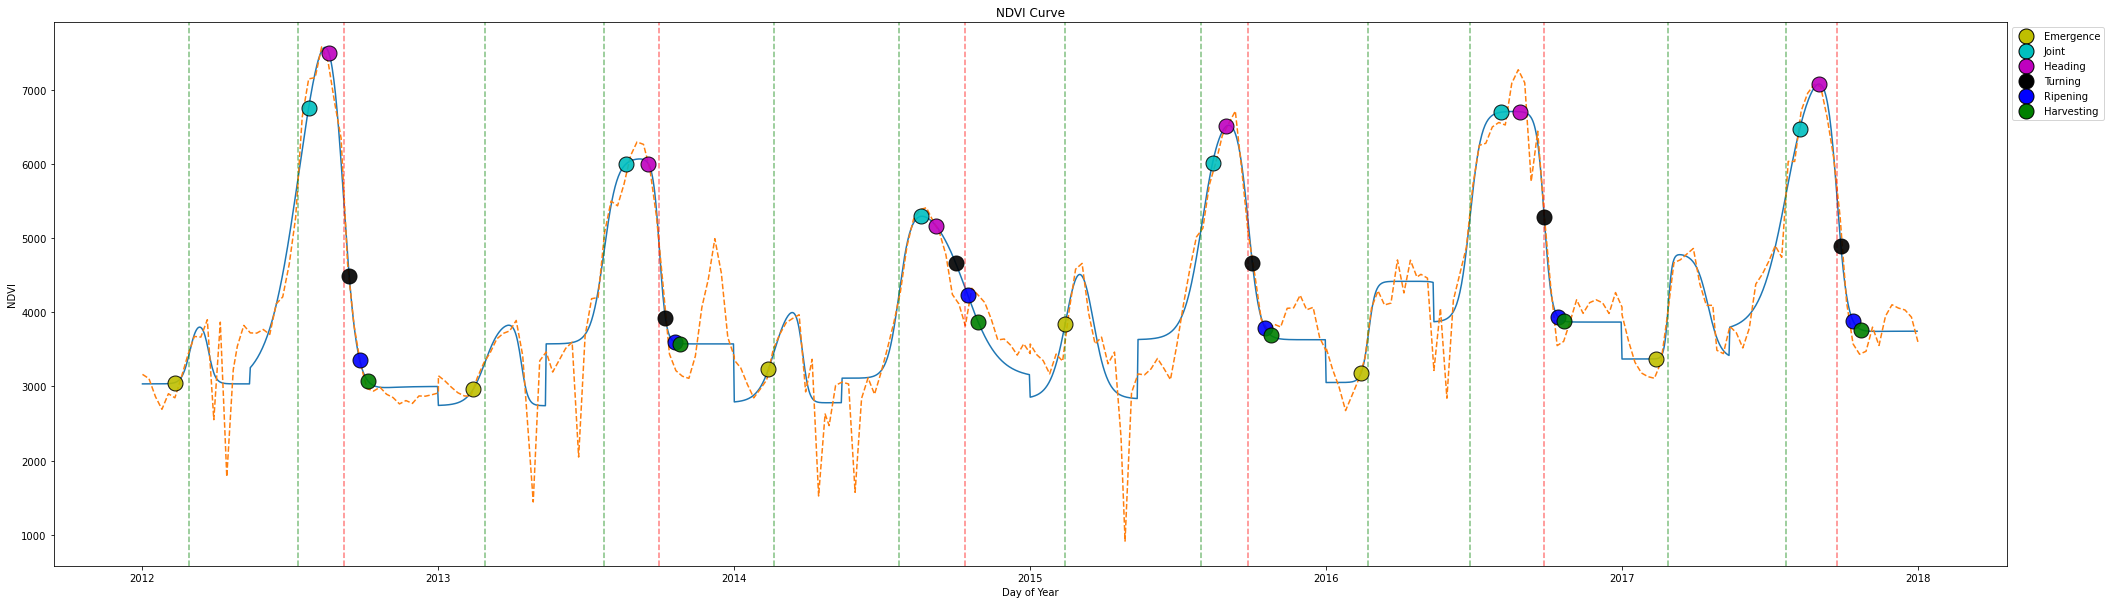

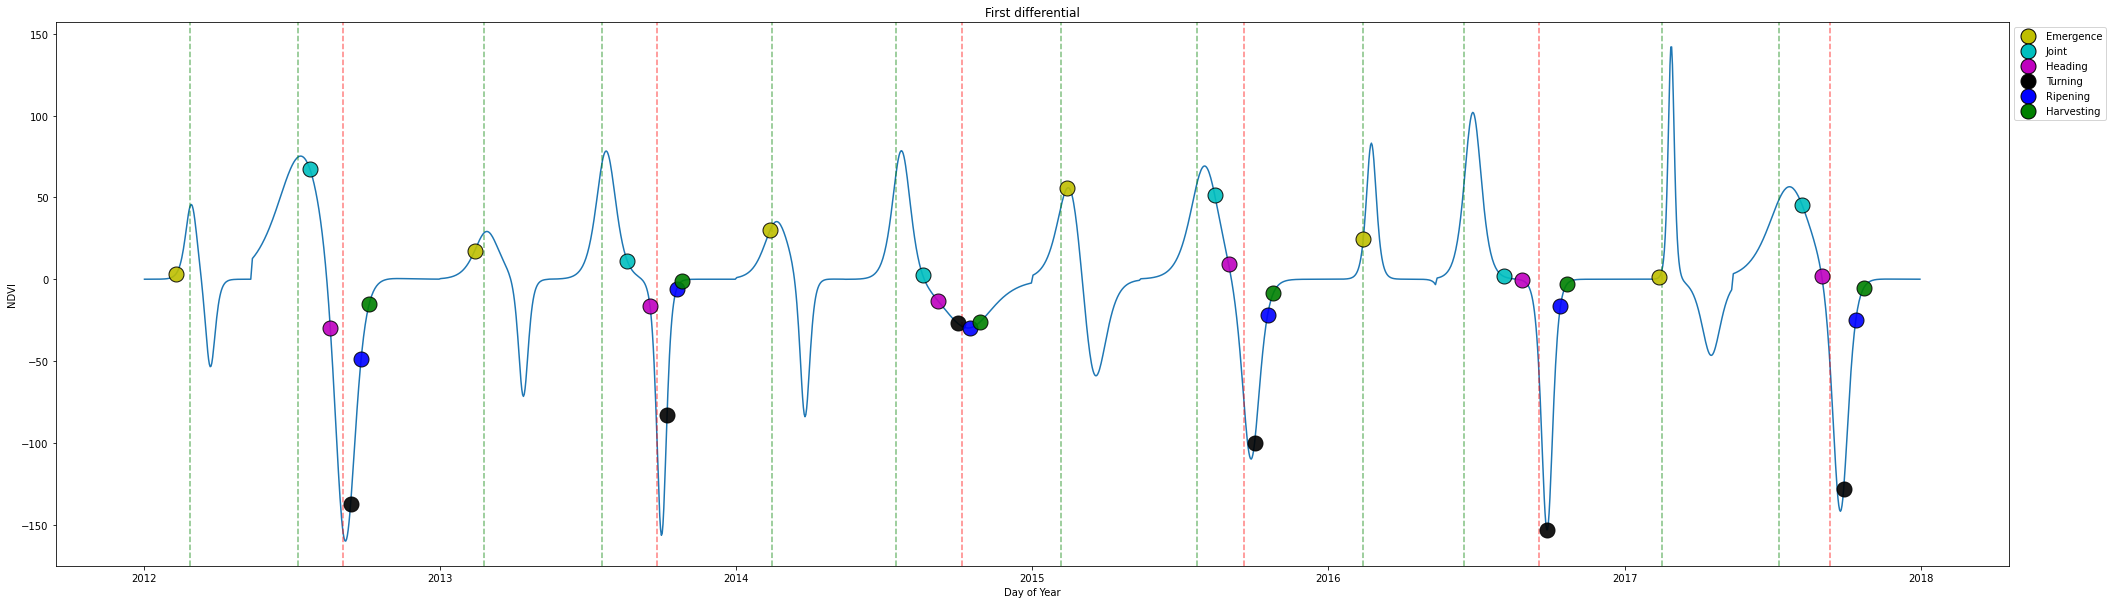

In [21]:
def zip_data():
    return zip(
        vegetative_greenups, reproductive_greenups, reproductive_senescense, 
        crop_emergence_dates, joint_dates, heading_dates, turning_dates, ripening_dates, harvesting_dates
    )

plot_ndvi(
    doys, ndvis, 
    'NDVI Curve', 
    zip_data(),
    (doys_discrete,ndvis_discrete)
    # None
)

plot_ndvi(
    doys_diff1, ndvis_diff1, 
    'First differential', 
    zip_data(),
    None
)

# plot_ndvi(
#     doys_diff2, ndvis_diff2, 
#     'Second differential', 
#     get_data()
# )

# plot_ndvi(
#     doys_diff3, ndvis_diff3, 
#     'Third differential', 
#     zip_data(),
#     None
# )

## MAIN FLOW : Estimate Average APTT values

In [22]:
for i, year in tqdm(enumerate(range(aptt_start_year,aptt_end_year+1))):
    aptt_veg_path = os.path.join(output_aptt_path, 'APTT_winterwheat_vegetative_phase_'+str(year)+'.tif')
    aptt_rep_path = os.path.join(output_aptt_path, 'APTT_winterwheat_reproductive_phase_'+str(year)+'.tif')

    raster1=rasterio.open(aptt_veg_path)
    aptt1=raster1.read()
    raster2=rasterio.open(aptt_rep_path)
    aptt2=raster2.read()
    
    emergence_to_first_greenup = np.sum(aptt1[(181-273+crop_emergence_dates[i]):(181-273+vegetative_greenups[i]+1)], 0)
    emergence_to_first_greenup_value = np.true_divide(emergence_to_first_greenup.sum(),(emergence_to_first_greenup!=0).sum())
    
    # doy 180 corresponds to index 179 of aptt2
    joint_to_second_greenup = np.sum(aptt2[int(reproductive_greenups[i]-1):joint_dates[i]], 0)
    joint_to_second_greenup_value = np.true_divide(joint_to_second_greenup.sum(),(joint_to_second_greenup!=0).sum())
    
    ripening_to_end_of_senescence = np.sum(aptt2[int(reproductive_senescense[i]-1):ripening_dates[i]], 0)
    ripening_to_end_of_senescence_value = np.true_divide(ripening_to_end_of_senescence.sum(),(ripening_to_end_of_senescence!=0).sum())

    print(str(year)+'-'+str(year+1)+' growing season:')
    print('Emergence->first greenup: '+str(emergence_to_first_greenup_value))
    print('second_greenup->joint: '+str(joint_to_second_greenup_value))
    print('end of senescence->ripening: '+str(ripening_to_end_of_senescence_value))

1it [00:00,  1.91it/s]

2020-2021 growing season:
Emergence->first greenup: 11.01628429145553
second_greenup->joint: nan
end of senescence->ripening: nan
